# Advanced Lane Finding
The goals / steps of this project are the following:

1. Compute the **camera calibration** matrix and distortion coefficients given a set of chessboard images.
1. Apply a **distortion** correction to raw images.
1. Use color transforms, gradients, etc., to **create a thresholded binary image**.
1. Apply a perspective transform to rectify binary image (**"birds-eye view"**).
1. Detect lane pixels and fit to **find the lane boundary**.
1. Determine the **curvature** of the lane and vehicle position with respect to center.
1. **Warp** the detected lane boundaries back onto the original image.
1. **Output** visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration
First, I'll compute the camera calibration matrix and distortion coefficients using chessboard images.


In [15]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# Read the list of calibration images
image_paths = glob.glob('camera_cal/calibration*.jpg') 

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in calibration image 

# object points
chessboard_x = 9
chessboard_y = 6
objp = np.zeros((chessboard_y*chessboard_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_x,0:chessboard_y].T.reshape(-1,2)

# Go through every image
for image_path in image_paths:
    img =  cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_x,chessboard_y),None)

    # Save corners to arrays
    if True == ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw corners
        img = cv2.drawChessboardCorners(img, (chessboard_x, chessboard_y), corners, ret)
        saved_image = image_path.replace('camera_cal', 'output_images/draw_camera_cal')
        plt.imsave(saved_image, img)
        #plt.imshow(img)
        #plt.savefig(saved_image)

# Calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Go through every calibration image for undistorting 
cali_image_paths = glob.glob('camera_cal/*.jpg') 
for image_path in image_paths:
    cal_img = cv2.imread(image_path)

    # Distortion correction
    undist_cali = cv2.undistort(cal_img, mtx, dist, None, mtx)
    saved_path = image_path.replace('camera_cal/', 'output_images/undist_camera_cal/undist_')
    cv2.imwrite(saved_path,undist_cali)

## 2. Distortion correction 
With the distortion coefficients gotten from camra calibration, we can undistort all the images as following. 

In [16]:
# Go through every test image for undistorting image
test_image_paths = glob.glob('test_images/*.jpg') 
for test_image_path in test_image_paths:
    test_img = cv2.imread(test_image_path)

    # Distortion correction
    undist = cv2.undistort(test_img, mtx, dist, None, mtx)
    saved_undist_path = test_image_path.replace('test_images/', 'output_images/undist/undist_')
    cv2.imwrite(saved_undist_path,undist)


## 3. Create thresholded binary image
Use color transforms, gradients, etc., to create a thresholded binary image.

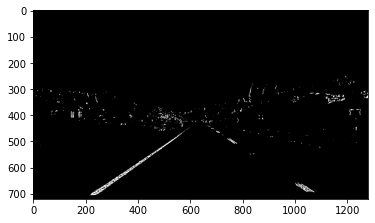

In [17]:
from Binary_Img import threshold_binary

# Define the thresholds
sobelx_threshold = (70, 170)
channel_threshold = (170, 255)
# Go through every undistortion image for creating thresholded binary image
undis_image_paths = glob.glob("output_images/undist/undist_*.jpg")
for undis_image_path in undis_image_paths:
    undist = cv2.imread(undis_image_path)
    binary = threshold_binary(undist, sobelx_threshold, channel_threshold)
    plt.imshow(binary, cmap='Greys_r')

    # Save the combined binary image
    saved_binary_path = undis_image_path.replace('undist', 'binary')
    cv2.imwrite(saved_binary_path,binary*255)


## 4. Birds-eye view
Apply the transform to every undisort image and save it to **birds_eye** folder.

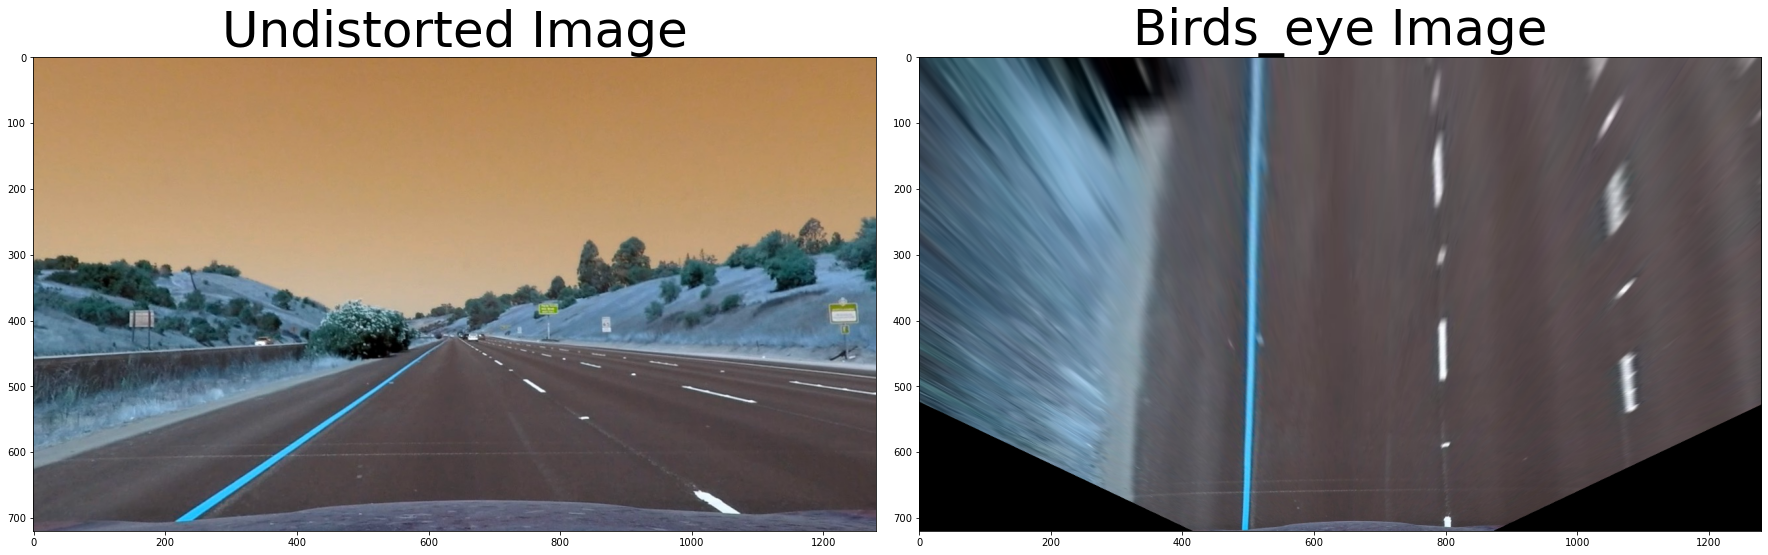

In [18]:
from Transform import transform_matrix
from Transform import transform

#undis_image_paths = glob.glob("output_images/undist/undist_*.jpg")

M, Min = transform_matrix()

# Go through all undistort image
for undis_image_path in undis_image_paths:
   
    undis_image = cv2.imread(undis_image_path)
    birds_eye_image = transform(M, undis_image)
    # Save the image
    birds_eye_image_path = undis_image_path.replace('undist', 'birds_eye')
    cv2.imwrite(birds_eye_image_path,birds_eye_image)
     


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undis_image)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(birds_eye_image)
ax2.set_title('Birds_eye Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Find the lane boundary
Detect lane pixels and fit to find the lane boundary.

In [19]:

from Finding_Lane import fit_polynomial

# Go through all warped image
birds_eye_image_paths = glob.glob("output_images/birds_eye/birds_eye_*.jpg")

for birds_eye_image_path in birds_eye_image_paths:
   
    birds_eye_image = cv2.imread(birds_eye_image_path)
    # Get the binary image for finding lane
    binary = threshold_binary(birds_eye_image, sobelx_thresh=(70, 170), channel_thresh=(170, 255))
    find_lane_path = birds_eye_image_path.replace('birds_eye', 'find_lane')
    find_lane_img = fit_polynomial(binary)[3]

    cv2.imwrite(find_lane_path,find_lane_img)

## 6. Lane curvature and vehicle position
Determine the curvature of the lane and vehicle position with respect to center.

In [20]:
from Curvature import measure_curvature_real
from Curvature import display_curvature
from Curvature import write_curvature

    # go through all image
birds_eye_image_paths = glob.glob("output_images/birds_eye/birds_eye_*.jpg")

ym_par_pix = 7/720
xm_par_pix= 3.7/300

for birds_eye_image_path in birds_eye_image_paths:   
    
    # read the image
    birds_eye_image = cv2.imread(birds_eye_image_path)

    # get the curvature image
    curvature_image = display_curvature(birds_eye_image, ym_par_pix, xm_par_pix)
    
    # write curvature display image
    curvature_path = birds_eye_image_path.replace("birds_eye", "curvature")
    cv2.imwrite(curvature_path,curvature_image)


## 7. Warp lane boundaries
Warp the detected lane boundaries back onto the original image.

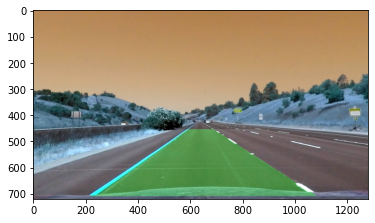

In [24]:
from Warp import show_warp_lane
from Warp import warp_lane

# Go through all images
for undis_image_path in undis_image_paths:   
      
    # Read image
    undis_image = cv2.imread(undis_image_path)
    birds_eye_image = transform(M, undis_image) 
    
    # get warped line image
    warped_lane = warp_lane(birds_eye_image, Min)
    show_warped_lane = show_warp_lane(undis_image, warped_lane)
    
    # save image
    lane_image_path = undis_image_path.replace("undist", "warped_lane")
    cv2.imwrite(lane_image_path, show_warped_lane)
    plt.imshow(show_warped_lane)



## 8. Visual display
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


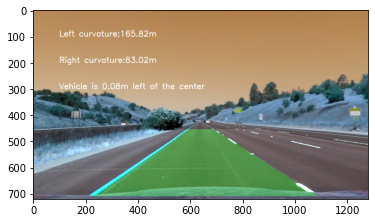

In [25]:
def visual_lane(img):
    birds_eye_image = transform(M, img) 
    
    # get warped line image
    warped_lane = warp_lane(birds_eye_image, Min)
    show_warped_lane = show_warp_lane(img, warped_lane)
    
    # add curvature and position value
    measure_binary = threshold_binary(birds_eye_image, sobelx_thresh=(70, 170), channel_thresh=(170, 255))
    left, right, veh_pos = measure_curvature_real(measure_binary, ym_par_pix, xm_par_pix)
    
    return write_curvature(show_warped_lane, left, right, veh_pos)
    
for undis_image_path in undis_image_paths:   
    
    # Read image
    undis_image = cv2.imread(undis_image_path)         

    result_img = visual_lane(undis_image)
    
    # save image
    visual_lane_image_path = undis_image_path.replace("undist", "visual_lane")
    cv2.imwrite(visual_lane_image_path, result_img)
    plt.imshow(result_img)

## 9. Video



In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_img(img):
    #undistort
    undis_img = cv2.undistort(img, mtx, dist, None, mtx)
    return visual_lane(undis_img)

video_output = 'test_videos_output/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")##.subclip(0,5)
white_clip = clip1.fl_image(process_img) 
%time white_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4


t:  49%|████▉     | 592/1199 [313:28:38<02:40,  3.79it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
CPU times: user 3min 45s, sys: 34.4 s, total: 4min 20s
Wall time: 7min


In [27]:
challenge_video_output = 'test_videos_output/challenge_video_output.mp4'

challenge_video_clip = VideoFileClip("challenge_video.mp4")##.subclip(0,5)
challenge_video_white_clip = challenge_video_clip.fl_image(process_img) #NOTE: this function expects color images!!
%time challenge_video_white_clip.write_videofile(challenge_video_output, audio=False)



t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]Moviepy - Building video test_videos_output/challenge_video_output.mp4.
Moviepy - Writing video test_videos_output/challenge_video_output.mp4


t:  49%|████▉     | 592/1199 [313:31:36<02:40,  3.79it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video_output.mp4
CPU times: user 1min 25s, sys: 7.7 s, total: 1min 33s
Wall time: 2min 18s


In [28]:
harder_challenge_video_output = 'test_videos_output/harder_challenge_video_output.mp4'

harder_challenge_video_clip = VideoFileClip("harder_challenge_video.mp4")##.subclip(0,5)
harder_challenge_video_white_clip = harder_challenge_video_clip.fl_image(process_img) 
%time harder_challenge_video_white_clip.write_videofile(harder_challenge_video_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]Moviepy - Building video test_videos_output/harder_challenge_video_output.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video_output.mp4


t:  49%|████▉     | 592/1199 [03:32<03:17,  3.08it/s, now=None]

TypeError: expected non-empty vector for x